In [1]:
import numpy as np
import xarray as xr
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
import timeit


import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# First check that the x axis y axis of the array are in multiples of the desired resolution ratio so that 
# resampling up and down will always result in an output of equal size to the original input DEM.
# In the case of MRVBF the reoslution ratio is 3 (but this can be varied).

def x_y_size_test(array, resolution_ratio):
    
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    
    # Check number of rows and calculate required additional rows.
    rows = np.size(array, 0)
    add_rows = resolution_ratio-(rows % resolution_ratio) 
    # Using % instead of divide will return the remainder as an integer.
    # The remainder is being deducted from three because that gives the required pad for and even number.
    
    # Check number of columns and calculate required additional rows.
    columns = np.size(array, 1)

    add_columns = resolution_ratio - (columns % resolution_ratio)
    
    empty_array = np.zeros((rows + add_rows, columns + add_columns)) # Create an empty array to the pad if required.
    
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    
    empty_array[:offset_rows, :offset_columns] = array
    
    return empty_array

In [3]:
location = (r'/g/data/xc0/user/walker/sjw603/dem_5m')
os.chdir(location)
ds = gdal.Open('wean_1m.tif')
input_DEM = np.array(ds.GetRasterBand(1).ReadAsArray())
DEM_subset = input_DEM[2000:2100, 2000:2100]


In [4]:
input_DEM.shape

(5452, 7906)

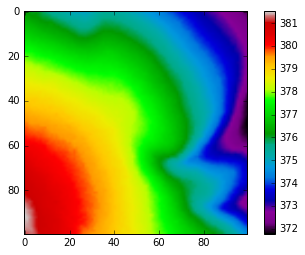

In [5]:
plt.imshow(DEM_subset, cmap="nipy_spectral")
plt.colorbar()

In [6]:
DEM = x_y_size_test(DEM_subset, 3)
DEM[DEM == -999] = 0
DEM.shape

(102, 102)

In [7]:
def rectangleWindow(m, n):
    
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    
    rectangle = np.ones((m, n), dtype=bool) 

    return rectangle

In [8]:
def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
        
    denominator = sum(sum(Window > 0))
    
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

In [9]:
def slopeWindow(DEM, x_cellsize, y_cellsize):
    
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
        
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
       
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    
    slope_percent = rise_run * 100

    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

In [10]:
# This would be a slope raster with slope represented as percent.
start = timeit.default_timer()

S1_sub = generic_filter(DEM_subset, slopeWindow, footprint= rectangleWindow(3,3), mode='constant', extra_arguments = (1,1,))

stop = timeit.default_timer()

print (stop - start) 

0.09420771000441164


In [11]:
# Define a function that takes a value for radius and creates a circular window using that radius.

def circleWindow(radius):
    
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle

In [12]:
circleWindow(3)

array([[False, False, False,  True, False, False, False],
       [False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [False, False, False,  True, False, False, False]], dtype=bool)

In [13]:
def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == circle type 'number_of_values(circleWindow(r)) 
        where r is any positive real number as per the circleWindow function."""
        
    denominator = sum(sum(Window > 0))
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.


In [14]:
def find_median_value(Window):
    
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value


In [15]:
find_median_value(circleWindow(3))

14

In [19]:
#This function calculates the percentile of a central value within its circular neighborhood.


def PCTL(x):
    
    """This function only works as an inside function to generic_filter function below. This
    is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
    step the 'central_value' variable will be outside of the array dimensions. 
    x = input DEM and r = radius of search window """
    
    centroid = x[central_value]                        
    y = np.sum(x > centroid) / num_values #Count number of values greater than centroid value
    
    return y


In [20]:
radius = 6

num_values = number_of_values(circleWindow(radius))

central_value = find_median_value(circleWindow(radius))

start = timeit.default_timer()

PCTL1 = generic_filter(DEM_subset, PCTL, footprint= circleWindow(radius), mode='constant')

stop = timeit.default_timer()

print (stop - start) 

0.10788741696160287


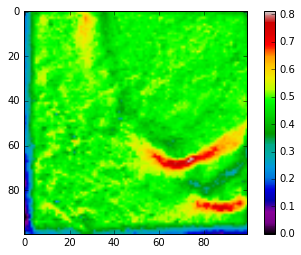

In [21]:
plt.imshow(PCTL1, cmap="nipy_spectral")
plt.colorbar()

In [22]:
radius = 3

num_values = number_of_values(circleWindow(radius))

central_value = find_median_value(circleWindow(radius))

start = timeit.default_timer()

PCTL1 = generic_filter(DEM_subset, PCTL, footprint= circleWindow(radius), mode='constant')

stop = timeit.default_timer()

print (stop - start) 

0.10432743595447391


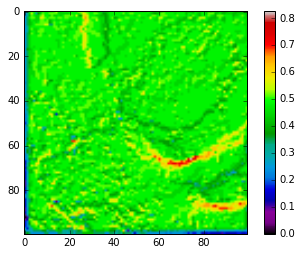

In [23]:
plt.imshow(PCTL1, cmap="nipy_spectral")
plt.colorbar()